In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob
import imageio
import pandas as pd

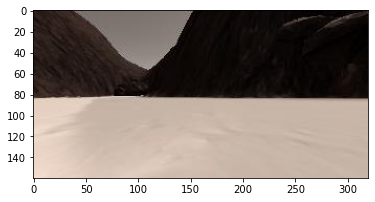

In [2]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0,len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

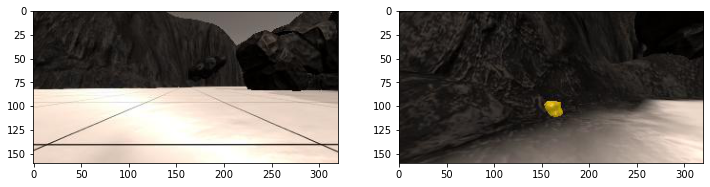

In [3]:
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock2.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
fig = plt.figure(figsize =(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

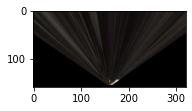

In [4]:
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    #mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1],img.shape[0]))
    return warped

#used a destination size of 10, for better fidelity, this does mess with collisions, need optimal number for phase 2
#offset of the warped image from the bottom
dst_size = 10
bottom_offset = 5


source = np.float32(([14,140],[300,140],[200,95],[120,95]))
destination = np.float32(([image.shape[1]/2 - dst_size, image.shape[0]-bottom_offset],
                         [image.shape[1]/2+dst_size, image.shape[0]-bottom_offset],
                         [image.shape[1]/2+dst_size, image.shape[0]-2*dst_size-bottom_offset],
                         [image.shape[1]/2 -dst_size, image.shape[0]-2*dst_size-bottom_offset]))
warped = perspect_transform(rock_img, source, destination)
plt.subplot(121)
plt.imshow(warped)

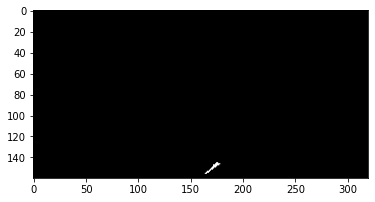

In [5]:
def color_thresh(img, rgb_thresh=(160,160,160),type=0):
    color_select =np.zeros_like(img[:,:,0])
    if type == 0:
        above_thresh = (img[:,:,0]>rgb_thresh[0])&(img[:,:,1]>rgb_thresh[1])&(img[:,:,2]>rgb_thresh[2])  # for navigable  
    elif type == 1:
        above_thresh = (img[:,:,0]>rgb_thresh[0])&(img[:,:,1]>rgb_thresh[1])&(img[:,:,2]<rgb_thresh[2])    #for rocks
    else:
        above_thresh = (img[:,:,0]>0)&(img[:,:,1]>-10)&(img[:,:,2]>-10)    #for mask
    color_select[above_thresh] = 1
    return color_select
threshold = color_thresh(warped,type=0)

plt.imshow(threshold, cmap='gray')

/var/folders/_2/p6lf6zxd5f17mfvjbyh19c9c0000gn/T/ipykernel_5723/1432448385.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/var/folders/_2/p6lf6zxd5f17mfvjbyh19c9c0000gn/T/ipykernel_5723/1432448385.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img

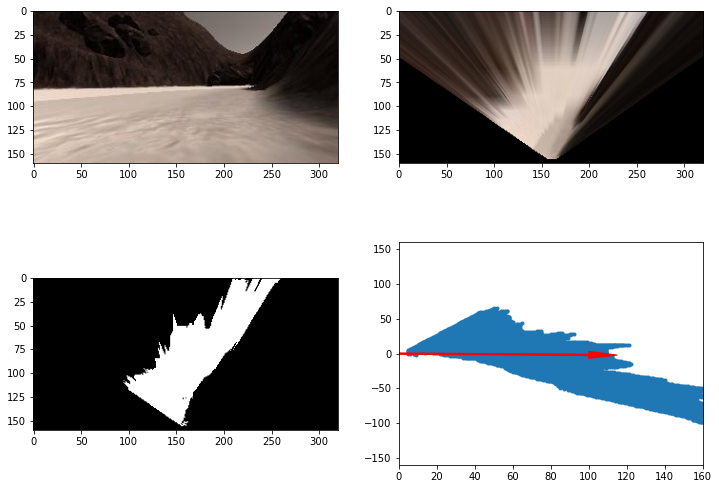

In [6]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1] / 2).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle)
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel ** 2 + y_pixel ** 2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles


# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))

    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result
    return xpix_rotated, ypix_rotated


def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[2])
warped = perspect_transform(image, source, destination)
threshold = color_thresh(warped)
obstacleMap = np.absolute(np.float32(threshold) - 1) * color_thresh(warped, type=2)
scale = 2*dst_size
#world_size = data.worldmap.shape[0]
#xpos = data.xpos[data.count]
#ypos = data.ypos[data.count]
#yaw = data.yaw[data.count]
obs_map = np.absolute(np.float32(color_thresh(warped,type=0))-1)*color_thresh(warped,type=2)
xpix, ypix = rover_coords(threshold)
#x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
obsxpix, obsypix = rover_coords(obstacleMap)
#x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshold, cmap = 'gray')
# plt.subplot(223)
# plt.imshow(obs_map, cmap = 'gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160,160)
plt.xlim(0,160)
arrow_length = 100
x_arrow = arrow_length *np.cos(mean_dir)
y_arrow = arrow_length *np.sin(mean_dir)
plt.arrow(0,0,x_arrow,y_arrow,color='red',zorder=2, head_width=10, width=2)






In [7]:

# this is the path to the csv file
df = pd.read_csv('../test_dataset/IMG/robot_log.csv', delimiter=';', decimal='.')
# list of image paths
csv_img_list = df["Path"].tolist() 

# creating 3 channel image for the map
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)






#  this class  will be a container. it will read each row from the csv file and create an object corresponds to it
class DataContainer():
    def __init__(self):
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.images = csv_img_list  
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap


data = DataContainer()


/var/folders/_2/p6lf6zxd5f17mfvjbyh19c9c0000gn/T/ipykernel_5723/1081671475.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
/var/folders/_2/p6lf6zxd5f17mfvjbyh19c9c0000gn/T/ipykernel_5723/1081671475.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

In [9]:
#stored images will be passed to this function
def process_image(img):
   
        
        #creating an empty image with zeros
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        
        # the original image will be in the upper left corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        #This is the warped image (perspective transformed) that is to be included too.
    warped = perspect_transform(img, source, destination)
    
        # the warped image will be in the upper right
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # it add the navigable terrain and the obstacles to the mini-map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    
    #moviepy skipping images bug fix
        
    if data.count < len(data.images) - 1:
        data.count += 1 
    
    return output_image

In [10]:
#fixing ffmpeg path bug 
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/local/bin/ffmpeg"

from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# this will be the output video
output = '../testVideo.mp4'
data = DataContainer() # Re-initialize the DataContainer
clip = ImageSequenceClip(data.images, fps=30) 

new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../testVideo.mp4.
Moviepy - Writing video ../testVideo.mp4



Moviepy - Done !
Moviepy - video ready ../testVideo.mp4
CPU times: user 1.08 s, sys: 339 ms, total: 1.42 s
Wall time: 2.25 s
